In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import os, fnmatch
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures 
import seaborn as sns
%matplotlib inline
from keras.layers import Input, Dense
from keras.models import Model
# from keras.op
from keras import optimizers
from keras import regularizers
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

Using TensorFlow backend.


In [2]:
class_path = "./DataCreation/Dataset/Train_8bit/"
data_train = []
data_train_names = os.listdir(class_path)
pattern = "*.tiff"
for entry in data_train_names:
    if fnmatch.fnmatch(entry, pattern):
            data_train.append(class_path+entry)

In [3]:
print(len(data_train_names), len(data_train))

9456 9456


In [4]:
class_path = "./DataCreation/Dataset/Test_8bit/"
data_test = []
data_test_names = os.listdir(class_path)
pattern = "*.tiff"
for entry in data_test_names:
    if fnmatch.fnmatch(entry, pattern):
            data_test.append(class_path+entry)

In [6]:
print(len(data_test_names), len(data_test))

2707 2707


In [7]:
data_train_list = []
for i in range(len(data_train)):
    arr_obj = []
    cl = (data_train[i].split("/")[4]).split("~~~")[0]
    if cl == "QSO" or cl == "Sy1" or cl == "WD" or cl == "cv":
        arr_obj.append(cl)
        arr_obj.append(data_train[i])
        data_train_list.append(arr_obj)
    
data_test_list = []
for i in range(len(data_test)):
    arr_obj = []
    cl = (data_test[i].split("/")[4]).split("~~~")[0]
    if cl == "QSO" or cl == "Sy1" or cl == "WD" or cl == "cv":
        arr_obj.append(cl)
        arr_obj.append(data_test[i])
        data_test_list.append(arr_obj)

In [8]:
print(len(data_train_list), len(data_test_list))

2624 754


In [9]:
df_train = pd.DataFrame(data_train_list)
df_test = pd.DataFrame(data_test_list)

In [10]:
df_train.head()

,0,1
0,cv,./DataCreation/Dataset/Train_8bit/cv~~~AC Cnc....
1,cv,./DataCreation/Dataset/Train_8bit/cv~~~AC Cnc_...
2,cv,./DataCreation/Dataset/Train_8bit/cv~~~AC Cnc_...
3,cv,./DataCreation/Dataset/Train_8bit/cv~~~AC Cnc_...
4,cv,./DataCreation/Dataset/Train_8bit/cv~~~AC Cnc_...


In [11]:
df_test.head()

,0,1
0,cv,./DataCreation/Dataset/Test_8bit/cv~~~AO Psc.tiff
1,cv,./DataCreation/Dataset/Test_8bit/cv~~~AO Psc_0...
2,cv,./DataCreation/Dataset/Test_8bit/cv~~~AO Psc_0...
3,cv,./DataCreation/Dataset/Test_8bit/cv~~~AO Psc_0...
4,cv,./DataCreation/Dataset/Test_8bit/cv~~~AO Psc_0...


In [12]:
df_train[0].value_counts()

QSO    1280
Sy1     665
WD      549
cv      130
Name: 0, dtype: int64

In [13]:
df_test[0].value_counts()

QSO    365
Sy1    190
WD     159
cv      40
Name: 0, dtype: int64

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_train[0])
df_train[0]=le.transform(df_train[0])

In [15]:
df_train[0].value_counts()

0    1280
1     665
2     549
3     130
Name: 0, dtype: int64

In [16]:
for index, Row in df_test.iterrows():
    cl = Row[0]
    if cl == 'QSO':
        df_test.at[index, 0] = 0
    elif cl == "Sy1":
        df_test.at[index, 0] = 1
    elif cl == "WD":
        df_test.at[index, 0] = 2
    elif cl == "cv":
        df_test.at[index, 0] = 3

In [17]:
df_test[0].value_counts()

0    365
1    190
2    159
3     40
Name: 0, dtype: int64

In [18]:
X_tr = df_train.iloc[:, 1]
Y_tr = df_train.iloc[:, 0]
X_tr = X_tr.values
Y_tr = Y_tr.values

X_ts = df_test.iloc[:, 1]
Y_ts = df_test.iloc[:, 0]
X_ts = X_ts.values
Y_ts = Y_ts.values

In [19]:
images_list_train = []
max_width = 0
max_height = 0
ind = 0
for i in range(len(X_tr)):
    im = Image.open(X_tr[i])
    arr = np.array(im)#.flatten()
    
    arr=(arr-arr.min())/(arr.max()-arr.min())
    #arr = arr / 0xffff
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list_train.append(arr)
    
images_list_test = []
ind = 0
for i in range(len(X_ts)):
    im = Image.open(X_ts[i])
    arr = np.array(im)#.flatten()
    
    arr=(arr-arr.min())/(arr.max()-arr.min())
    #arr = arr / 0xffff
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list_test.append(arr)

In [20]:
print(max_width, max_height)

20 140


In [21]:
for i in range(len(images_list_train)):
    s = images_list_train[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list_train[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list_train[i] = arr.flatten()

for i in range(len(images_list_test)):
    s = images_list_test[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list_test[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list_test[i] = arr.flatten()

20 140


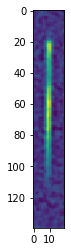

In [22]:
width = max_width
height = max_height
print(width, height)
plt.imshow(images_list_train[25].reshape(140, 20))

In [23]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras
#print(device_lib.list_local_devices())

config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [26]:
images_np_train = np.array(images_list_train)
images_np_test = np.array(images_list_test)

In [27]:
class_count = 4
X_train = images_np_train
Y_train = Y_tr
Y_train = keras.utils.to_categorical(Y_train, class_count)

X_test = images_np_test
Y_test = Y_ts
Y_test = keras.utils.to_categorical(Y_test, class_count)

In [28]:
X_train = X_train.reshape(X_train.shape[0], 140, 20, 1)
X_test = X_test.reshape(X_test.shape[0], 140, 20, 1)
input_shape = (140, 20, 1)

In [29]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (2624, 140, 20, 1)
2624 train samples
754 test samples


In [37]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), input_shape=input_shape, padding="same"))
model.add(MaxPooling2D(pool_size=(3, 1)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 1)))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 4)))

model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(Dense(4,activation=tf.nn.softmax))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 140, 20, 128)      1280      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 46, 20, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 20, 64)        73792     
_________________________________________________________________
activation_5 (Activation)    (None, 46, 20, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 20, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 20, 32)        18464     
_________________________________________________________________
activation_6 (Activation)    (None, 15, 20, 32)        0         
__________

In [39]:
adadelta = optimizers.Adadelta(lr=0.05, rho=0.95)
model.compile(optimizer=adadelta , loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
cw = {0:1, 1:1, 2:1, 3:1}
history = model.fit(X_train, Y_train, epochs = 4, batch_size = 32, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw)

Train on 2624 samples, validate on 754 samples
Epoch 1/4
2624/2624 [==============================] - 15s 6ms/step - loss: 1.2807 - acc: 0.3929 - val_loss: 1.1836 - val_acc: 0.4841
Epoch 2/4
2624/2624 [==============================] - 15s 6ms/step - loss: 1.1995 - acc: 0.4653 - val_loss: 1.1770 - val_acc: 0.4841
Epoch 3/4
2624/2624 [==============================] - 15s 6ms/step - loss: 1.1822 - acc: 0.4787 - val_loss: 1.1659 - val_acc: 0.4841
Epoch 4/4
2624/2624 [==============================] - 15s 6ms/step - loss: 1.1753 - acc: 0.4760 - val_loss: 1.1574 - val_acc: 0.4841


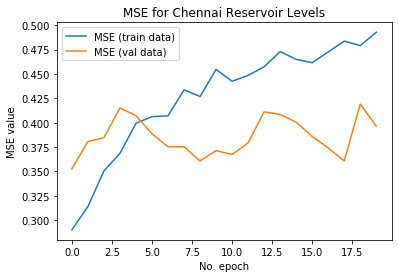

In [39]:
plt.plot(history.history['acc'], label='MSE (train data)')
plt.plot(history.history['val_acc'], label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [32]:
prediction = model.predict(X_test)

In [33]:
for i in range(len(prediction)):
    prediction[i] = prediction[i] > 0.5

In [34]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

print('Accuracy:', accuracy_score(Y_test, prediction))
print ('F1 score:', f1_score(Y_test, prediction, average = "weighted"))
print ('Recall:', recall_score(Y_test, prediction, average = "weighted"))
print ('Precision:', precision_score(Y_test, prediction, average = "weighted"))
print ('\n clasification report:\n', classification_report(Y_test,prediction))
print ('\n confussion matrix:\n',confusion_matrix(Y_test, prediction))

Accuracy: 0.40848806366047746
F1 score: 0.42697632982828376
Recall: 0.40848806366047746
Precision: 0.5568650650690959

 clasification report:
               precision    recall  f1-score   support

           0       0.56      0.31      0.40       365
           1       0.41      0.73      0.52       190
           2       0.71      0.35      0.47       159
           3       0.67      0.05      0.09        40

   micro avg       0.49      0.41      0.45       754
   macro avg       0.58      0.36      0.37       754
weighted avg       0.56      0.41      0.43       754
 samples avg       0.41      0.41      0.41       754



C:\Users\Ghevond\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


ValueError: multilabel-indicator is not supported